### <center style="background-color:Gainsboro; width:60%;">Load Data</center>
The very first steps are to load the data and get a quick understanding of what it is and how we can use it to fulfill out goal:

"For each `<session_id>_<question #>`, you are predicting the `correct` column, identifying whether you believe the user for this particular session will answer this question correctly, using only the previous information for the session.

The timeseries API presents the questions and data to you in order of levels - level segments 0-4, 5-12, and 13-22 are each provided in sequence, and you will be predicting the correctness of each segment's questions as they are presented."

In [1]:
#=========================================================================
# Load up the libraries
#=========================================================================
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import gc
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GroupKFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#=========================================================================
# Load in the data
#=========================================================================
test  = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv')
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

Note: I have been having extreme issues with RAM given the size of the dataset, and in transferring this to Kaggle I found I had to adopt code from another notebook or else reduce the dataset I used. It seems like the LHL-provided examples on how to do XGBoost classification do not work on my system with this dataset (the competition appears to have been changed only a few months ago), so some of this notebook uses code from a prior submission/baseline project that breaks it up into chunks that are processed individually. Otherwise, my features, effort, and outcome are dependent on my work from before finding this notebook.

In [3]:
# READ USER ID ONLY
tmp = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 12
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 12 pieces of sizes:
[2208580, 2238585, 2181336, 2209139, 2203924, 2213922, 2188184, 2177814, 2160779, 2188720, 2166242, 2159721]


### <center style="background-color:Gainsboro; width:60%;">Feature Selection & Engineering</center>
Starting off, `session_id` in the labels DF has a `_qX` suffix, indicating which question was answered. This can be split into two columns, although the `session_id` column is also being treated as the index column so it needs to be reset first.

In [4]:
#=========================================================================
# reset index, split session_id
#=========================================================================
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q_answered'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( labels.shape )
labels.head()

(424116, 4)


,session_id,correct,session,q_answered
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


I also want my final df to have features that would be missing, such as `elapsed_time`, so the `numbers` list has been used for that reason. 

In [5]:
#=========================================================================
# define typed lists
#=========================================================================
# For Engineering
categories = ['event_name', 'fqid', 'room_fqid', 'text']

events = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

# For retaining features
numbers = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

#=========================================================================
# create engineered dataframe
#=========================================================================
def feature_engineer(train):
    # Create list of new dfs to later merge together
    eng_df = []

    # We don't really need the exact data for these columns
    for cat in categories:
        temp = train.groupby(['session_id','level_group'])[cat].agg('nunique')
        temp.name = temp.name + '_nunique'
        eng_df.append(temp)

    # Simplify events data
    for step in events:
        train[step] = (train.event_name == step).astype('int8')
    for step in events + ['elapsed_time']:
        temp = train.groupby(['session_id','level_group'])[step].agg('sum')
        temp.name = temp.name + '_sum'
        eng_df.append(temp)

    # Keep numerical data
    for step in numbers:
        temp = train.groupby(['session_id','level_group'])[step].agg('sum')
        eng_df.append(temp)

    # Drop 
    train = train.drop(events,axis=1)

    df = pd.concat(eng_df,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [6]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

Processing train as 12 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 

Shape of all train data after feature engineering: (70686, 23)
CPU times: user 3min 46s, sys: 13 s, total: 3min 59s
Wall time: 4min 42s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration
session_id,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,81,22,28,11,4,8,2,4,1,14155937,14155937,321,0.0,1201.398834,-11140.544849,69952.0,59755.0,19116.0
20090312431273200,13-22,10,49,12,168,170,123,60,20,14,10,6,3,1,437052322,437052322,7309,0.0,-51096.090454,-63505.689523,173456.0,148686.0,24298.0
20090312431273200,5-12,10,39,11,124,103,104,12,28,9,9,8,1,1,105732736,105732736,2384,0.0,3791.106501,-15176.370454,119767.0,100378.0,29080.0
20090312433251036,0-4,11,22,6,49,49,18,36,15,3,5,3,2,1,13571045,13571045,260,0.0,-10925.974736,-6977.240641,46569.0,48194.0,11030.0
20090312433251036,13-22,11,73,16,183,637,145,65,83,186,14,45,5,1,3241011333,3241011333,23038,255.0,-32115.822788,-149147.814734,483218.0,404999.0,181537.0


In [7]:
labels = labels.reset_index()
print(f"Length = {len(labels)}")
labels = labels.drop("index", axis=1)
labels.head()

Length = 424116


,session_id,correct,session,q_answered
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


### <center style="background-color:Gainsboro; width:60%;">XGBoost Model</center>
Now that I have my cleaned training data in `df`, I need to build he model. I have the following considerations to keep in mind.
1. The `labels` df has a column for individual questions (i.e. level within a group), with the primary key being session_id.
2. The new training `df` has a column for level group, but not for individual questions.

In [8]:
features = [c for c in df.columns if c != 'level_group']
print(len(features))
user_list = df.index.unique()
print(len(user_list))

22
23562


In [9]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(user_list),18)), index=user_list)
models = {}

# CV score with 5 group kfold
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4}
    
    # Iterate through questions in labels df
    for t in range(1,19):
        
        # Use this to train data based on groupings that match training set
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = labels.loc[labels.q_answered==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = labels.loc[labels.q_answered==t].set_index('session').loc[valid_users]
        
        # Train Model        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[features].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[features].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # Save model, predict valid OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[features].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(203), 2(111), 3(172), 4(279), 5(136), 6(112), 7(68), 8(87), 9(152), 10(174), 11(107), 12(100), 13(157), 14(204), 15(138), 16(62), 17(55), 18(148), 
#########################
### Fold 2
#########################
1(193), 2(145), 3(133), 4(115), 5(115), 6(95), 7(129), 8(53), 9(135), 10(96), 11(114), 12(138), 13(253), 14(198), 15(222), 16(128), 17(80), 18(120), 
#########################
### Fold 3
#########################
1(180), 2(190), 3(109), 4(190), 5(105), 6(101), 7(113), 8(71), 9(100), 10(173), 11(64), 12(72), 13(74), 14(202), 15(199), 16(72), 17(144), 18(192), 
#########################
### Fold 4
#########################
1(179), 2(130), 3(107), 4(172), 5(131), 6(130), 7(91), 8(70), 9(89), 10(112), 11(150), 12(120), 13(157), 14(193), 15(229), 16(79), 17(75), 18(228), 
#########################
### Fold 5
#########################
1(156), 2(131), 3(188), 4(234), 5(161), 6(111), 7(109), 8(52), 9(99), 10(213), 11(71), 

### <center style="background-color:Gainsboro; width:60%;">Compute CV Score</center>
Again borrowing from a baseline submission on Kaggle given RAM limitations...

In [10]:
# Create DF with 18 columns
true = oof.copy()
for k in range(18):
    tmp = labels.loc[labels.q_answered == k+1].set_index('session').loc[user_list]
    true[k] = tmp.correct.values

In [11]:
# Determine best threshold for converting probabilities into 1s and 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.50,0.78,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 

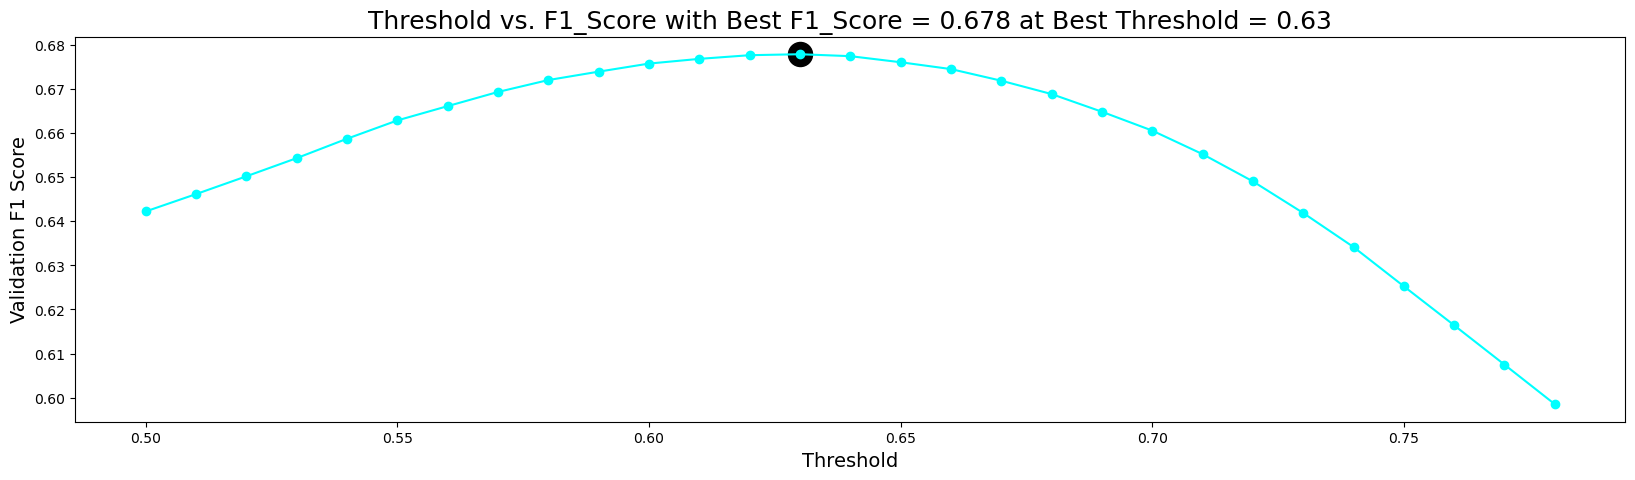

In [12]:
# Plot
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='cyan')
plt.scatter([best_threshold], [best_score], color='black', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [13]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5988997759257804
Q1: F1 = 0.49462711537224113
Q2: F1 = 0.4872240555363134
Q3: F1 = 0.6135720682831779
Q4: F1 = 0.5730062007340059
Q5: F1 = 0.6085708935193549
Q6: F1 = 0.5844127249512925
Q7: F1 = 0.534353127804959
Q8: F1 = 0.5976904938224648
Q9: F1 = 0.5164169383157339
Q10: F1 = 0.5874781473455001
Q11: F1 = 0.4962597836513874
Q12: F1 = 0.43805071377181115
Q13: F1 = 0.6072980717879813
Q14: F1 = 0.5102407369464745
Q15: F1 = 0.4670639554216723
Q16: F1 = 0.5352604743303182
Q17: F1 = 0.49501655335114375
==> Overall F1 = 0.6779460794067447


### <center style="background-color:Gainsboro; width:60%;">Submission</center>

In [14]:
true.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
20090313091715820,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1
20090313571836404,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1


In [15]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, df, oof, true
_ = gc.collect()

ModuleNotFoundError: No module named 'jo_wilder.competition'